In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as Ftorch

import torch.optim as optim

from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())


font = {'family' : 'DejaVu Sans',
        'weight' : 'normal', 
        'size'   : 18}

matplotlib.rc('font', **font)

In [16]:
# load the data
csv_path = os.path.join("data", "data_single_stat.csv")
df = pd.read_csv(csv_path)

csv_path = os.path.join("data", "data_amdahlspace.csv")
df_amd = pd.read_csv(csv_path)

df_spdup = pd.read_csv(os.path.join("data", "data_speedup.csv"))
df_spdup.columns = df_spdup.columns.str.replace(' ', '')
df_spdup

sql = """
SELECT df.*, df_amd.F, df_amd.Lambda, df_amd.ThreadOpt, df_spdup.Thread, df_spdup.SpeedUp
FROM df
LEFT JOIN df_amd, df_spdup
ON df.Name=df_amd.Name AND df.Size=df_amd.Size AND df_spdup.Name=df.Name AND df_spdup.Size=df.Size
"""

df_ = pysqldf(sql).dropna()


dfname = df_amd[['Name', 'Size']]
df_

,Name,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,F,Lambda,ThreadOpt,Thread,SpeedUp
0,blackscholes,simlarge,9.641823e+08,2.158,1.698940e+07,15.662867,1.084609e+08,9.733166e+09,6.443532e+09,0.662,4162.194667,138634.533333,2.617347e+09,3.752222e+07,1.616560e+07,0.148831,0.000746,32,1,1.000000
1,blackscholes,simlarge,9.641823e+08,2.158,1.698940e+07,15.662867,1.084609e+08,9.733166e+09,6.443532e+09,0.662,4162.194667,138634.533333,2.617347e+09,3.752222e+07,1.616560e+07,0.148831,0.000746,32,2,1.758076
2,blackscholes,simlarge,9.641823e+08,2.158,1.698940e+07,15.662867,1.084609e+08,9.733166e+09,6.443532e+09,0.662,4162.194667,138634.533333,2.617347e+09,3.752222e+07,1.616560e+07,0.148831,0.000746,32,3,2.259268
3,blackscholes,simlarge,9.641823e+08,2.158,1.698940e+07,15.662867,1.084609e+08,9.733166e+09,6.443532e+09,0.662,4162.194667,138634.533333,2.617347e+09,3.752222e+07,1.616560e+07,0.148831,0.000746,32,4,2.760459
4,blackscholes,simlarge,9.641823e+08,2.158,1.698940e+07,15.662867,1.084609e+08,9.733166e+09,6.443532e+09,0.662,4162.194667,138634.533333,2.617347e+09,3.752222e+07,1.616560e+07,0.148831,0.000746,32,5,3.040167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,vips,simsmall,8.180313e+08,2.018,1.883699e+07,17.819000,1.057069e+08,7.622309e+09,5.691609e+09,0.748,3278.152000,141653.000000,1.994411e+09,3.675400e+07,1.818348e+07,0.097436,0.006106,12,28,3.308226
828,vips,simsmall,8.180313e+08,2.018,1.883699e+07,17.819000,1.057069e+08,7.622309e+09,5.691609e+09,0.748,3278.152000,141653.000000,1.994411e+09,3.675400e+07,1.818348e+07,0.097436,0.006106,12,29,3.269922
829,vips,simsmall,8.180313e+08,2.018,1.883699e+07,17.819000,1.057069e+08,7.622309e+09,5.691609e+09,0.748,3278.152000,141653.000000,1.994411e+09,3.675400e+07,1.818348e+07,0.097436,0.006106,12,30,3.231618
830,vips,simsmall,8.180313e+08,2.018,1.883699e+07,17.819000,1.057069e+08,7.622309e+09,5.691609e+09,0.748,3278.152000,141653.000000,1.994411e+09,3.675400e+07,1.818348e+07,0.097436,0.006106,12,31,3.193314


In [81]:
# normalize
def leave_one_out(tgt_idx=0, tgt_thread=4):
    X = df_[df_['Thread'] == tgt_thread][
        [
            'branch-misses in %',
            'page-faults', 
            'L3-cache-miss-rate in %',
            'L1-instruction-cache-load-misses', 
            'total-instructions', 
            'IPC'
        ]
    ].to_numpy()
    

    y = df_[df_['Thread'] == tgt_thread][['SpeedUp']].to_numpy()
    
    opt = df_[df_['Thread'] == tgt_thread][['ThreadOpt']].to_numpy()
    

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    Xlegend = dfname.to_numpy()

    X_mean, X_std = torch.mean(X, dim=0), torch.std(X, dim=0)
    X = (X - X_mean) / X_std
    X = X.float()

    y_mean, y_std = torch.mean(y, dim=0), torch.std(y, dim=0)
    y = (y - y_mean) / y_std
    y = y.float()

    # shuffle
#     idx = torch.randperm(X.size()[0])
    train_idx = [i for i in range(X.size()[0]) if not i == tgt_idx]
    test_idx = [tgt_idx]

    # split train/test
    X_train, X_test = X[train_idx], X[test_idx]
    lgd_train, lgd_test = Xlegend[train_idx], Xlegend[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    opt_train, opt_test = opt[train_idx], opt[test_idx]
    
    return X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean.numpy(), y_std.numpy(), opt_train, opt_test

X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, opt_train, opt_test = leave_one_out(tgt_idx=25, tgt_thread=4)

print(lgd_test)
print(X_train.size(), X_test.size())
print(y_train.size(), y_test.size())
print(opt_test)

[['vips' 'simsmall']]
torch.Size([25, 6]) torch.Size([1, 6])
torch.Size([25, 1]) torch.Size([1, 1])
[[12]]


In [133]:
def generate_pred_report(predict_sample):
    threads = [4, 8, 16, 32]
    data = []
    
    ests = []
    gts = []
    
    gt_opts = []
    
        
    
    for t in threads:
        spd_ests = []
        spd_gts = []

        for idx in range(26):
            y_est, y_gt, opt_gt = predict_sample(idx, t)

            spd_ests.append(y_est)
            spd_gts.append(y_gt)
            
            if t == threads[0]:
                gt_opts.append(opt_gt)
            

        diff = np.array(spd_ests) - np.array(spd_gts)


        mse_err = np.mean(np.abs(diff))
        
        err_std = np.std(np.abs(diff))
        data.append([t, mse_err, err_std])
        
        ests.append(spd_ests)
        gts.append(spd_gts)
        
    ests = torch.from_numpy(np.array(ests))
    gts = torch.from_numpy(np.array(gts))
    
    threads = torch.from_numpy(np.array(threads))
    est_opts = threads[torch.argmax(ests, 0)].numpy()
    gt_opts = np.array(gt_opts)
    diff_opts = np.abs(est_opts - gt_opts)
    
#     print("Mean Absoulte Error(Optimal thread): {:.3f}".format(np.mean(diff_opts)))
    
    return pd.DataFrame(data, columns=['Thread', "Mean Absolute Error", "Std. Abolute Error"])

In [149]:
from sklearn.linear_model import LinearRegression

def predict_sample(idx=0, thread=4):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, opt_train, opt_test = leave_one_out(tgt_idx=idx, tgt_thread=thread)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_est = float(model.predict(X_test) * y_std + y_mean)
    y_gt = float(y_test * y_std + y_mean)
    
    return y_est, y_gt, float(opt_test)

print("Linear Regression")
generate_pred_report(predict_sample)

Linear Regression


,Thread,Mean Absolute Error,Std. Abolute Error
0,4,0.258448,0.274098
1,8,0.711136,0.717489
2,16,1.857727,1.467456
3,32,1.813439,1.587511


Linear Regression


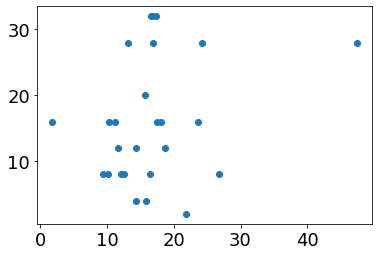

Mean Absoulte Error: 8.686


In [124]:
from sklearn.linear_model import LinearRegression

def predict_sample(idx=0):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, opt_train, opt_test = leave_one_out(tgt_idx=idx)

    model = LinearRegression()
    model.fit(X_train, opt_train)

    y_est = float(model.predict(X_test))
    y_gt = opt_test
    
    return y_est, y_gt

print("Linear Regression")


thrd_ests = []
thrd_gts = []

for idx in range(26):
    y_est, y_gt = predict_sample(idx)
    
    thrd_ests.append(y_est)
    thrd_gts.append(float(y_gt))


plt.scatter(thrd_ests, thrd_gts)
plt.show()
    
diff = np.array(thrd_ests) - np.array(thrd_gts)

mae_err = np.mean(np.abs(diff))
err_std = np.std(np.abs(diff))

print("Mean Absoulte Error: {:.3f}".format(mae_err))


In [142]:
from sklearn.neighbors import KNeighborsRegressor

def predict_sample(idx=0, thread=4):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, _, opt_test = leave_one_out(tgt_idx=idx, tgt_thread=thread)

    model = KNeighborsRegressor(n_neighbors=3)
    model.fit(X_train, y_train)

    y_est = float(model.predict(X_test) * y_std + y_mean)
    y_gt = float(y_test * y_std + y_mean)
    
    return y_est, y_gt, float(opt_test)

print("KNN")
generate_pred_report(predict_sample)

KNN


,Thread,Mean Absolute Error,Std. Abolute Error
0,4,0.389432,0.261239
1,8,0.829327,0.593811
2,16,1.321936,1.064707
3,32,1.333033,1.199317


KNeighborsRegressor


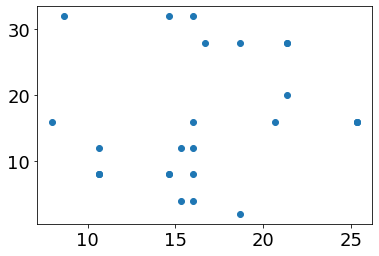

Mean Absoulte Error: 8.103


In [136]:
from sklearn.neighbors import KNeighborsRegressor

def predict_sample(idx=0):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, opt_train, opt_test = leave_one_out(tgt_idx=idx)

    model = KNeighborsRegressor(n_neighbors=3)
    model.fit(X_train, opt_train)

    y_est = float(model.predict(X_test))
    y_gt = opt_test
    
    return y_est, y_gt

print("KNeighborsRegressor")


thrd_ests = []
thrd_gts = []

for idx in range(26):
    y_est, y_gt = predict_sample(idx)
    
    thrd_ests.append(y_est)
    thrd_gts.append(float(y_gt))


plt.scatter(thrd_ests, thrd_gts)
plt.show()
    
diff = np.array(thrd_ests) - np.array(thrd_gts)

mae_err = np.mean(np.abs(diff))
err_std = np.std(np.abs(diff))

print("Mean Absoulte Error: {:.3f}".format(mae_err))


In [143]:
from sklearn.ensemble import RandomForestRegressor

def predict_sample(idx=0, thread=4):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, _, opt_test = leave_one_out(tgt_idx=idx, tgt_thread=thread)

    model = RandomForestRegressor(max_depth=2, random_state=0)
    model.fit(X_train, y_train.reshape(-1))

    y_est = float(model.predict(X_test) * y_std + y_mean)
    y_gt = float(y_test * y_std + y_mean)
    
    return y_est, y_gt, float(opt_test)

print("Random Forest")
generate_pred_report(predict_sample)

Random Forest


,Thread,Mean Absolute Error,Std. Abolute Error
0,4,0.431825,0.328649
1,8,1.024350,0.823746
2,16,1.634928,1.572281
3,32,1.534662,1.535147


RandomForestRegressor


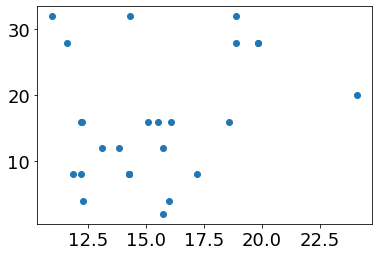

Mean Absoulte Error: 7.159


In [138]:
from sklearn.ensemble import RandomForestRegressor

def predict_sample(idx=0):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, opt_train, opt_test = leave_one_out(tgt_idx=idx)

    model = RandomForestRegressor(max_depth=2, random_state=0)
    model.fit(X_train, opt_train.reshape(-1))

    y_est = float(model.predict(X_test))
    y_gt = opt_test
    
    return y_est, y_gt

print("RandomForestRegressor")


thrd_ests = []
thrd_gts = []

for idx in range(26):
    y_est, y_gt = predict_sample(idx)
    
    thrd_ests.append(y_est)
    thrd_gts.append(float(y_gt))


plt.scatter(thrd_ests, thrd_gts)
plt.show()
    
diff = np.array(thrd_ests) - np.array(thrd_gts)

mae_err = np.mean(np.abs(diff))
err_std = np.std(np.abs(diff))

print("Mean Absoulte Error: {:.3f}".format(mae_err))


In [139]:
from sklearn.tree import DecisionTreeRegressor

def predict_sample(idx=0, thread=4):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, _, opt_test = leave_one_out(tgt_idx=idx, tgt_thread=thread)

    model = DecisionTreeRegressor(max_depth=2, random_state=0)
    model.fit(X_train, y_train.reshape(-1))

    y_est = float(model.predict(X_test) * y_std + y_mean)
    y_gt = float(y_test * y_std + y_mean)
    
    return y_est, y_gt, float(opt_test)

print("Decision Tree")
generate_pred_report(predict_sample)

Decision Tree


,Thread,Mean Absolute Error,Std. Abolute Error
0,4,0.460841,0.408025
1,8,1.390632,0.949555
2,16,2.123039,2.059311
3,32,2.735234,2.050702


DecisionTreeRegressor


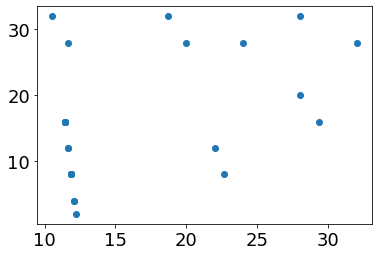

[-21.44444444 -16.31578947  -4.         -13.33333333  -0.33333333
  13.33333333  -8.           8.          -4.           3.88888889
   3.88888889   3.88888889  -4.55555556   3.88888889   8.11111111
  -4.55555556  -0.33333333   3.88888889  14.66666667   8.11111111
  10.22222222   4.          -4.55555556  -4.55555556  -4.55555556
  10.        ]
Mean Absoulte Error: 7.170


In [141]:
from sklearn.tree import DecisionTreeRegressor

def predict_sample(idx=0):
    X_train, X_test, y_train, y_test, lgd_train, lgd_test, y_mean, y_std, opt_train, opt_test = leave_one_out(tgt_idx=idx)

    model = DecisionTreeRegressor(max_depth=2, random_state=0)
    model.fit(X_train, opt_train.reshape(-1))

    y_est = float(model.predict(X_test))
    y_gt = opt_test
    
    return y_est, y_gt

print("DecisionTreeRegressor")


thrd_ests = []
thrd_gts = []

for idx in range(26):
    y_est, y_gt = predict_sample(idx)
    
    thrd_ests.append(y_est)
    thrd_gts.append(float(y_gt))


plt.scatter(thrd_ests, thrd_gts)
plt.show()
    
diff = np.array(thrd_ests) - np.array(thrd_gts)

print(diff)

mae_err = np.mean(np.abs(diff))
err_std = np.std(np.abs(diff))

print("Mean Absoulte Error: {:.3f}".format(mae_err))